## Importing Useful Python Libraries or package 

In [22]:
import datetime
import pandas as pd
from PIL import Image
import requests
import io
import glob, os, sys, time, uuid

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw



In [23]:
from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType
from msrest.authentication import CognitiveServicesCredentials

## Accessing Specific Azure Resources 

In [35]:
AVKASH_FACE_KEY = "Bb18EZ7tReQZUzXpGZz75UB2YA9zpVa7MfacnRBhzeQa6yGrNerBJQQJ99AJACYeBjFXJ3w3AAAKACOGF9jj"
AVKASH_FACE_ENDPOINT = "https://dung-face.cognitiveservices.azure.com/"

In [25]:
# Create a client
face_client = FaceClient(AVKASH_FACE_ENDPOINT, CognitiveServicesCredentials(AVKASH_FACE_KEY))

In [26]:
face_client.api_version

'1.0'

## Lets take a look at the 4 images we have

- #### You must be wondering where did I got these 4 faces. Actually they belong a to a video which was processed from Azure Video analyzer service and these 4 faces were exteacted from that video via Azure video analyser service. 
- #### In the Azure Video Analyzer Demo, I will go ahead and show you I have got these faces and saved them to the local disk. Alternative, we can store them to the Azure blob storage or some other storage at the internet and reference them from their URL.


### You can get these images from the source below to your local disk:
- https://raw.githubusercontent.com/Avkash/demoapps/master/resources/human-face1.jpg
- https://raw.githubusercontent.com/Avkash/demoapps/master/resources/human-face2.jpg
- https://raw.githubusercontent.com/Avkash/demoapps/master/resources/human-face3.jpg
- https://raw.githubusercontent.com/Avkash/demoapps/master/resources/human-face4.jpg


In [27]:
# List of image URLs to fetch
image_urls = [
    "https://raw.githubusercontent.com/Avkash/demoapps/master/resources/human-face1.jpg",
    "https://raw.githubusercontent.com/Avkash/demoapps/master/resources/human-face2.jpg",
    "https://raw.githubusercontent.com/Avkash/demoapps/master/resources/human-face3.jpg",
    "https://raw.githubusercontent.com/Avkash/demoapps/master/resources/human-face4.jpg"
]

# Directory to save images
output_directory = "downloaded_faces"
os.makedirs(output_directory, exist_ok=True)

# Download images
for idx, url in enumerate(image_urls):
    response = requests.get(url)
    if response.status_code == 200:
        # Construct a file path
        image_filename = os.path.join(output_directory, f"human-face-{idx + 1}.jpg")
        with open(image_filename, 'wb') as file:
            file.write(response.content)
    else:
        print(f"Failed to download image from {url}")

In [28]:
!ls human-face*.jpg

zsh:1: no matches found: human-face*.jpg


In [36]:
#my_face_images = [file for file in glob.glob('*.jpg') if file.startswith("human-face")]
#print(my_face_images)

my_face_images = [file for file in glob.glob(f'{output_directory}/*.jpg') if file.startswith(f"{output_directory}/human-face")]
print("Downloaded Images:", my_face_images)


Downloaded Images: ['downloaded_faces/human-face-4.jpg', 'downloaded_faces/human-face-3.jpg', 'downloaded_faces/human-face-2.jpg', 'downloaded_faces/human-face-1.jpg']


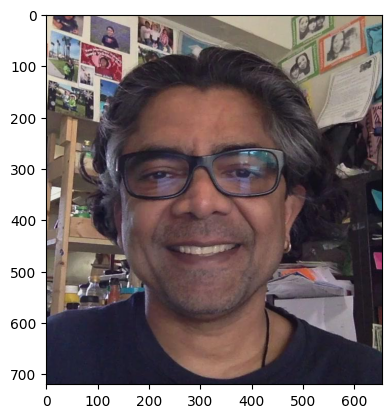

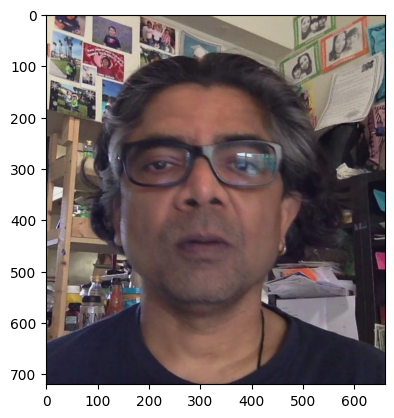

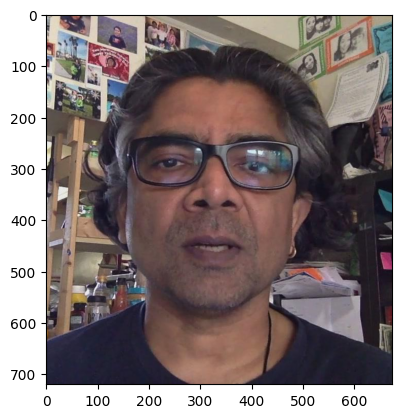

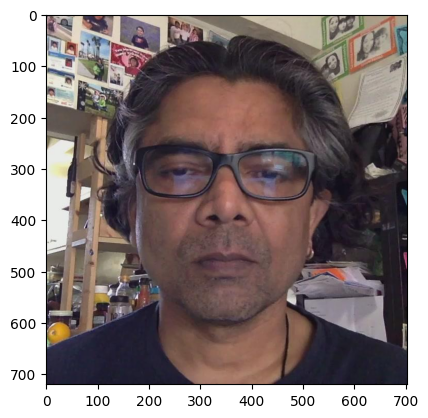

In [37]:
for img in my_face_images:
    with open(img, 'rb') as img_code:
        img_view_ready = Image.open(img_code)
        plt.figure()
        plt.imshow(img_view_ready)

https://github.com/Azure-Samples/cognitive-services-quickstart-code/blob/master/python/Face/DetectIdentifyFace.py

# Creating Person Model based on 4 faces we have

In [38]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = 'person-avkash'

In [61]:
## This code is taken from Azure face SDK 
## ---------------------------------------
def build_person_group(client, person_group_id, pgp_name):
    print('Create and build a person group...')
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print('Person group ID:', person_group_id)
    client.person_group.create(person_group_id = person_group_id, name=person_group_id)

    # Create a person group person.
    my_face = client.person_group_person.create(person_group_id, pgp_name)
    # Find all jpeg images of women in working directory.
    my_face_images = [file for file in glob.glob('*.jpg') if file.startswith("human-face")]
    # Add images to a woman Person object
    for image_p in my_face_images:
        with open(image_p, 'rb') as w:
            client.person_group_person.add_face_from_stream(person_group_id, my_face.person_id, w)

    # Train the person group, after a Person object with many images were added to it.
    client.person_group.train(person_group_id)

    # Wait for training to finish.
    while (True):
        training_status = client.person_group.get_training_status(person_group_id)
        print("Training status: {}.".format(training_status.status))
        if (training_status.status is TrainingStatusType.succeeded):
            break
        elif (training_status.status is TrainingStatusType.failed):
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit('Training the person group has failed.')
        time.sleep(5)


In [62]:
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)

Create and build a person group...
Person group ID: cdf3dbcc-22e1-443c-87ea-8e5648c9a75a


APIErrorException: (InvalidRequest) Invalid request has been sent.

# Making sure the person model has faces and they are all same person
- ### We are detect all faces in query image list, then add their face IDs to a new list.
- ### this face id list will be used 


In [34]:
'''
Detect all faces in query image list, then add their face IDs to a new list.
'''
def detect_faces(client, query_images_list):
    print('Detecting faces in query images list...')

    face_ids = {} # Keep track of the image ID and the related image in a dictionary
    for image_name in query_images_list:
        image = open(image_name, 'rb') # BufferedReader
        print("Opening image: ", image.name)
        time.sleep(5)

        # Detect the faces in the query images list one at a time, returns list[DetectedFace]
        faces = client.face.detect_with_stream(image)  

        # Add all detected face IDs to a list
        for face in faces:
            print('Face ID', face.face_id, 'found in image', os.path.splitext(image.name)[0]+'.jpg')
            # Add the ID to a dictionary with image name as a key.
            # This assumes there is only one face per image (since you can't have duplicate keys)
            face_ids[image.name] = face.face_id

    return face_ids

In [25]:
test_images = [file for file in glob.glob('*.jpg') if file.startswith("human-face")]

In [26]:
test_images

['human-face4.jpg', 'human-face1.jpg', 'human-face2.jpg', 'human-face3.jpg']

## Now lets view the face specific thumbnails 

In [27]:
ids = detect_faces(face_client, test_images)

Detecting faces in query images list...
Opening image:  human-face4.jpg
Face ID ab6ab6ab-871a-48bf-86c7-e99ba9d32171 found in image human-face4.jpg
Opening image:  human-face1.jpg
Face ID fd6e2092-bbad-46db-8b63-6b2493363b3e found in image human-face1.jpg
Opening image:  human-face2.jpg
Face ID 070ae26b-f54f-483a-a729-2afbaf3a91bb found in image human-face2.jpg
Opening image:  human-face3.jpg
Face ID 9b6b8e38-8351-4af9-96c1-1905002265e1 found in image human-face3.jpg


In [28]:
ids

{'human-face4.jpg': 'ab6ab6ab-871a-48bf-86c7-e99ba9d32171',
 'human-face1.jpg': 'fd6e2092-bbad-46db-8b63-6b2493363b3e',
 'human-face2.jpg': '070ae26b-f54f-483a-a729-2afbaf3a91bb',
 'human-face3.jpg': '9b6b8e38-8351-4af9-96c1-1905002265e1'}

### Lets verifying that 2 random images from the list belong to same person
- #### Note: So far we have not used the face recognition part, just only face detection

In [29]:
# Verification example for faces of the same person.
verify_result = face_client.face.verify_face_to_face(ids['human-face1.jpg'], ids['human-face2.jpg'])

In [30]:
if verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.92711.


## Now matching face from ID card with Video Analyzer Face 

In [31]:
def show_image_in_cell(face_url):
    response = requests.get(face_url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(10,5))
    plt.imshow(img)
    plt.show()

In [32]:
dl_source_url = 'https://raw.githubusercontent.com/Avkash/demoapps/master/resources/ca-dl-sample.png'

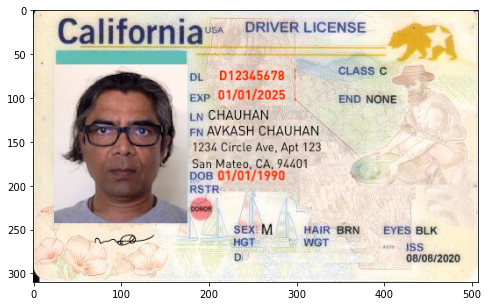

In [33]:
show_image_in_cell(dl_source_url)

In [34]:
## -------
## Reading file locally
## -------
# If I had image file locally I would have used the following method
# dl_image = open('/your-local-file-system/udacity/cal-dl.png', 'rb')
# dl_faces = face_client.face.detect_with_stream(dl_image)  

In [39]:
dl_faces = face_client.face.detect_with_url(dl_source_url) 

df6bbfc3-5985-4606-a4e3-5792cdbd9f97


## Viewing Face ID and then saved it into the list of already saved Face IDs

In [40]:
for face in dl_faces:
    print('Face ID', face.face_id, 'found in image', dl_source_url)
    # Add the ID to a dictionary with image name as a key.
    # This assumes there is only one face per image (since you can't have duplicate keys)
    ids['ca-dl-sample.png'] = face.face_id

Face ID df6bbfc3-5985-4606-a4e3-5792cdbd9f97 found in image https://raw.githubusercontent.com/Avkash/demoapps/master/resources/ca-dl-sample.png


## Now will have 4 + 1 = 5 Face IDs in our face ID list

In [41]:
ids

{'human-face4.jpg': 'ab6ab6ab-871a-48bf-86c7-e99ba9d32171',
 'human-face1.jpg': 'fd6e2092-bbad-46db-8b63-6b2493363b3e',
 'human-face2.jpg': '070ae26b-f54f-483a-a729-2afbaf3a91bb',
 'human-face3.jpg': '9b6b8e38-8351-4af9-96c1-1905002265e1',
 'ca-dl-sample.png': 'df6bbfc3-5985-4606-a4e3-5792cdbd9f97'}

## Let's perform Face Verification between the Face ID from identity card and one of the face ID from the video

In [42]:
# Verification example for faces of the same person.
dl_verify_result = face_client.face.verify_face_to_face(ids['human-face4.jpg'], ids['ca-dl-sample.png'])

In [43]:
if dl_verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(dl_verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(dl_verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.79158.


In [44]:
ids['ca-dl-sample.png']

'df6bbfc3-5985-4606-a4e3-5792cdbd9f97'

In [45]:
ids.values()

dict_values(['ab6ab6ab-871a-48bf-86c7-e99ba9d32171', 'fd6e2092-bbad-46db-8b63-6b2493363b3e', '070ae26b-f54f-483a-a729-2afbaf3a91bb', '9b6b8e38-8351-4af9-96c1-1905002265e1', 'df6bbfc3-5985-4606-a4e3-5792cdbd9f97'])

In [46]:
dl_faces[0].face_rectangle.as_dict()

{'width': 99, 'height': 99, 'left': 53, 'top': 110}

In [47]:
# TAKEN FROM THE Azure SDK Sample
# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))

In [48]:
def drawFaceRectangles(source_file, datected_face_object) :
    # Download the image from the url
    response = requests.get(source_file)
    img = Image.open(BytesIO(response.content))
    # Draw a red box around every detected faces
    draw = ImageDraw.Draw(img)
    for face in datected_face_object:
        draw.rectangle(getRectangle(face), outline='red', width = 10)
    return img

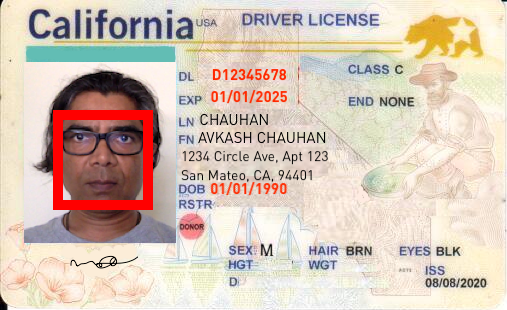

In [49]:
drawFaceRectangles(dl_source_url, dl_faces)

## Matching Face ID from Identity card with Video Analyzer Person Model 

In [50]:
# A list of Face ID
ids

{'human-face4.jpg': 'ab6ab6ab-871a-48bf-86c7-e99ba9d32171',
 'human-face1.jpg': 'fd6e2092-bbad-46db-8b63-6b2493363b3e',
 'human-face2.jpg': '070ae26b-f54f-483a-a729-2afbaf3a91bb',
 'human-face3.jpg': '9b6b8e38-8351-4af9-96c1-1905002265e1',
 'ca-dl-sample.png': 'df6bbfc3-5985-4606-a4e3-5792cdbd9f97'}

## Using the face Id belongs to identify Card and matching the identity with the person group Mode

In [56]:
get_the_face_id_from_the_driving_license = 'correct_face_id_here'
get_the_face_id_from_the_driving_license = 'df6bbfc3-5985-4606-a4e3-5792cdbd9f97'

In [57]:
person_gp_results = face_client.face.identify([get_the_face_id_from_the_driving_license], PERSON_GROUP_ID)

In [58]:
for result in person_gp_results:
    for candidate in result.candidates:
        print("The Identity match confidence is {}".format(candidate.confidence))

The Identity match confidence is 0.82948
